In [1]:
# System libraries
import time
import io
import itertools

# Custom libraries
import dl_utils as utils
import load_mnist as mnist

# Helper libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
train, _, test = mnist.read_mnist('mnist/',flatten=True)

class LogisticRegression:    
    
    def __init__(self, epochs = 50, log='False', session_type='cpu'):
        self.batch_size = 128
        self.epochs = epochs
        self.lr = 0.001
        self.log = log
        self.logdir = './graphs/logistic'
        self.sess_type = session_type
        
        #self.session = session_type
        tf.reset_default_graph()
        
    def set_session(self):
        '''
        Set a new tf session cpu/gpu
        '''
        if self.sess_type == 'cpu':
            sess = tf.Session()
        else:
            sess = utils.gpu_session()
            print("GPU session loaded...")
        
        return sess
    
    def get_data(self):
        
        with tf.name_scope('data'):

            # Define tf.Data and Iterators
            train_data = tf.data.Dataset.from_tensor_slices(train)
            test_data = tf.data.Dataset.from_tensor_slices(test)

            # Define data batches
            train_data = train_data.batch(self.batch_size, drop_remainder=False)
            test_data = test_data.batch(self.batch_size, drop_remainder=False)

            # Define an iterator
            iterator = tf.data.Iterator.from_structure(train_data.output_types,
                                                       train_data.output_shapes)

            # Take the next sample
            self.img, self.label = iterator.get_next()

            # Define an operation for multiple epochs
            self.train_init = iterator.make_initializer(train_data)
            self.test_init  = iterator.make_initializer(test_data)
            
            ## Create weight in shape of mnist dataset and bias initialised to 0
            self.w = tf.get_variable(name='weights', shape=(784, 10), initializer=tf.random_normal_initializer(0, 0.01))
            self.b = tf.get_variable(name='bias', shape=(1, 10), initializer=tf.zeros_initializer())

    def loss(self):
        '''
        Define Loss function
        '''
        ## Predict x*w + b
        self.logits = tf.matmul(self.img,self.w) + self.b    
        
        ## Defines entropy
        self.entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.label, logits=self.logits,name='loss')
        
        ## Computes the mean over all the examples in the batch
        self.loss = tf.reduce_mean(self.entropy, name='loss')

    def predict(self):
        '''
        Define prediction and accuracy
        '''        
        ## Build Model - Define Preds ##
        self.preds = tf.nn.softmax(self.logits)
        self.correct_preds = tf.equal(tf.argmax(self.preds, 1), tf.argmax(self.label, 1))
        self.accuracy = tf.reduce_sum(tf.cast(self.correct_preds, tf.float32))
        
    def optimizer(self):
        '''
        Define gradient descent as the optimizer to minimise the loss
        '''
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)

    def logistic_model(self):
        '''
        Train and evaluate model
        :param epochs: number of epochs
        '''
        sess = self.set_session()
        sess.run(tf.global_variables_initializer())
        print("Training...")
        for epoch in range(1, self.epochs+1):

            sess.run(self.train_init)
            total_loss = 0
            local_batch = 0
            batch_acc = 0
            train_acc = 0
            n_batches = 0
            try:
                while True:
                    _, batch_loss, batch_acc = sess.run([self.optimizer, self.loss, self.accuracy])
                    total_loss += batch_loss
                    train_acc += batch_acc
                    n_batches += self.batch_size
                    local_batch += 1
                    
            except tf.errors.OutOfRangeError:
                pass
            if epoch % 10 == 0:
                print('Epoch {:d} - Train loss: {:.3f} - Train Accuracy: {:.2f}%'.format (
                    epoch, 
                    total_loss/local_batch,
                    (train_acc/n_batches) * 100))

        # Test the model
        print("\nEvaluating...")
        sess.run(self.test_init) # drawing samples from test_data
        sum_preds = []
        test_accuracy = 0
        test_loss = 0
        try:
            while True:
                batch_preds, batch_loss, batch_accuracy = sess.run([self.preds, self.loss, self.accuracy])
                test_loss += batch_loss
                local_batch += 1                
                test_accuracy += batch_accuracy
                sum_preds.append(batch_preds)
                
        except tf.errors.OutOfRangeError:
            pass
        
        print("Test Validation loss: {:.3f}, Validation Accuracy: {:.2f}%".format(
                test_loss/local_batch,
                test_accuracy/len(test[1]) * 100))
        
        if self.log:
            writer = tf.summary.FileWriter(self.logdir,sess.graph) 
            self.log_confusion_matrix(sum_preds)

            # Merge with the other summaries
            merged = tf.summary.merge_all()
            summary = sess.run(merged)
            writer.add_summary(summary)
            writer.close()
        
        return sum_preds

    def plot_confusion_matrix(self, cm, class_names):
        '''
        Returns a matplotlib figure containing the plotted confusion matrix.
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
        '''
        figure = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        return figure

    def plot_to_image(self,figure):
        '''
        Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call.
        '''
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        
        # Add the batch dimension
        image = tf.expand_dims(image, 0)

        return image   
    
    def log_confusion_matrix(self,sum_preds):
        '''
        Convert predictions -> confusion matrix -> tensorboard object
        '''
        # Use the model to predict the values from the validation dataset.
        predictions = np.argmax(np.concatenate(sum_preds),axis=1)

        # Calculate the confusion matrix.
        cm = confusion_matrix(np.argmax(test[1][:len(predictions)],axis=1), predictions)
        
        # Convert image to tensor
        cm_image = self.plot_to_image(self.plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7,8,9]))

        # Log the confusion matrix as an image summary.
        tf.summary.image("Confusion_Matrix", cm_image,max_outputs=1)

    def plot_predictions(self, predictions):
        '''
        Make a subplot of random test images-predicted label
        '''
        # Choose 10 random images to infere
        rnd_inference = np.random.randint(0,10000,10)
        predicted_classes = np.argmax(np.concatenate(predictions),axis=1)

        # Plot images with their predicted labels
        plt.figure(figsize=(28,28))
        for idx,image in enumerate(rnd_inference):
            plt.subplot(10,1,1+idx)
            plt.title("Predicted Number: "+ str(predicted_classes[image]))
            fig = plt.imshow(np.reshape(test[0][image],(28,28)), cmap='gray')
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)    
            
    def build_graph(self):
        '''
        Build computational graph and train the model
        '''
        self.get_data()
        self.loss()
        self.optimizer()
        self.predict()

In [7]:
lr = LogisticRegression()

In [8]:
lr.build_graph()

In [9]:
preds = lr.logistic_model()

GPU session loaded...
Training...
Epoch 10 - Train loss: 0.875 - Train Accuracy: 83.36%
Epoch 20 - Train loss: 0.652 - Train Accuracy: 85.67%
Epoch 30 - Train loss: 0.564 - Train Accuracy: 86.66%
Epoch 40 - Train loss: 0.514 - Train Accuracy: 87.30%
Epoch 50 - Train loss: 0.482 - Train Accuracy: 87.82%

Evaluating...
Test Validation loss: 0.071, Validation Accuracy: 88.64%


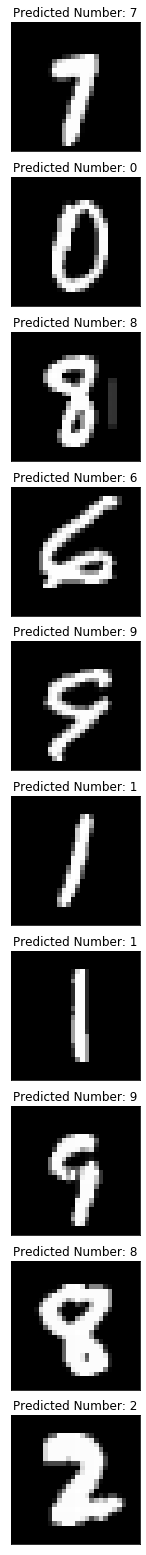

In [10]:
lr.plot_predictions(preds)

In [11]:
%load_ext tensorboard
%tensorboard --logdir graphs/logistic/ --port 1111